In [12]:
# !pip install --upgrade IPython

In [32]:
# %matplotlib notebook

import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
norm = matplotlib.colors.Normalize()

%matplotlib inline

from shapely.geometry import box, Polygon

In [51]:
ds = xr.open_dataset(f'cases/cook_island/out_files/MDK_SIM_2023_11_15_1150_cook_island/spill_properties.nc')
land = gpd.read_file('/Users/iatake/Dropbox (CMCC)/gshhg-shp-2.3.7/GSHHS_shp/i/GSHHS_i_L1.shp')
# curr = xr.open_dataset(f'/Users/iatake/Dropbox (CMCC)/Work/MEDSLIK-II and Pyslick/Medslik-II/cases/test3/oce_files/CMEMS_med_2023815_raw.nc')
# curr = curr.sel(depth=[0,10,30,120],method='nearest')
# curr = curr.resample(time="1H").interpolate("linear")
# curr

/var/folders/k4/jt3tnjj96t551zphcp5z9t5w0000gp/T/ipykernel_6340/282461163.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 8))


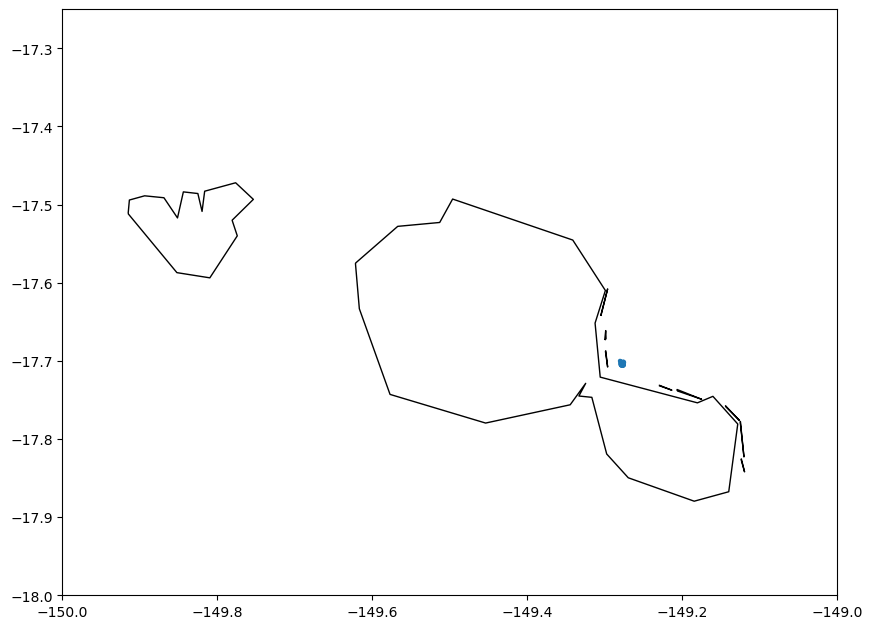

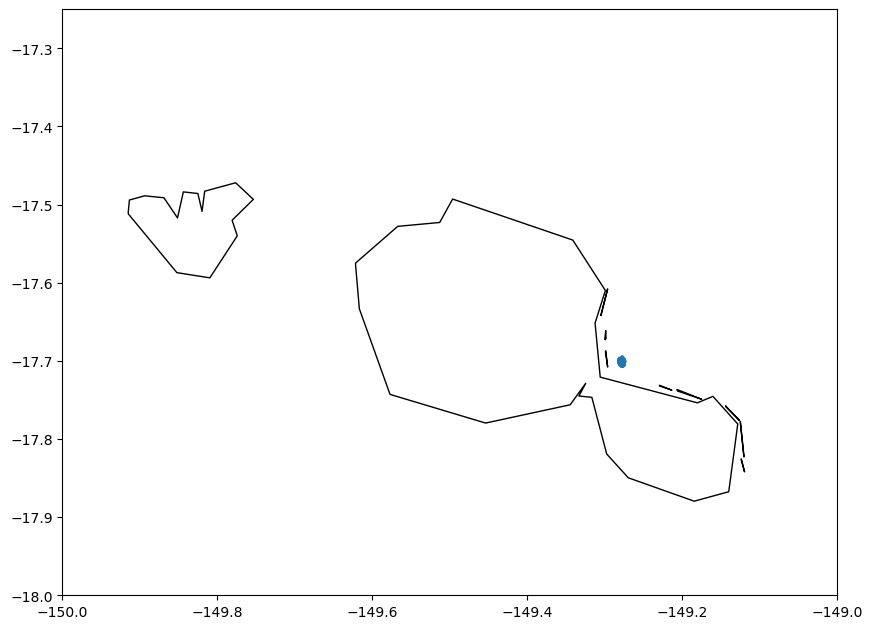

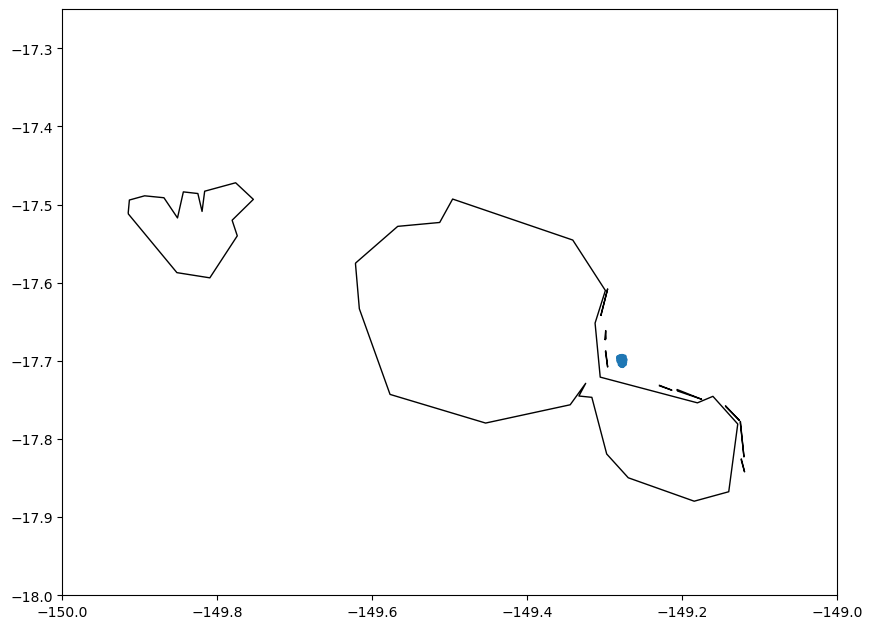

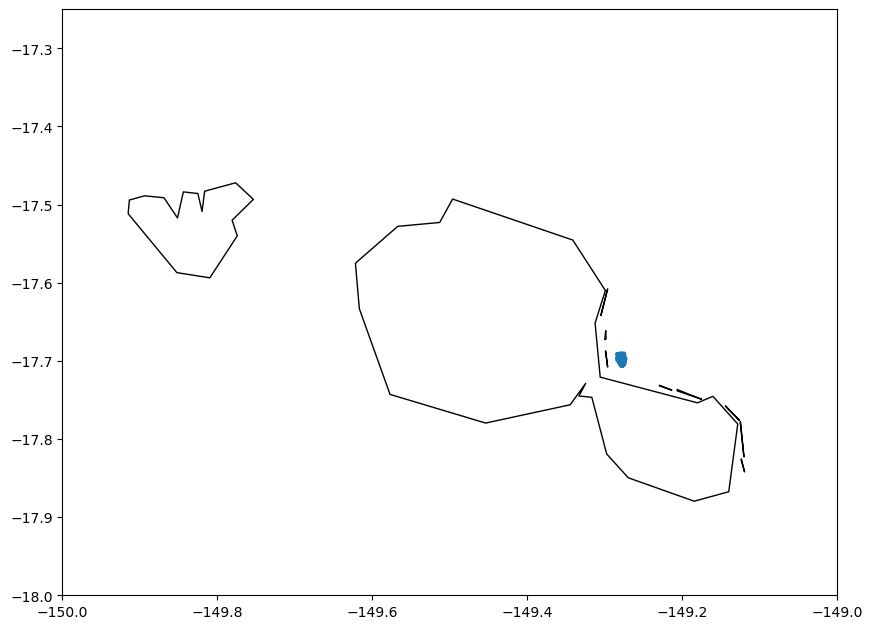

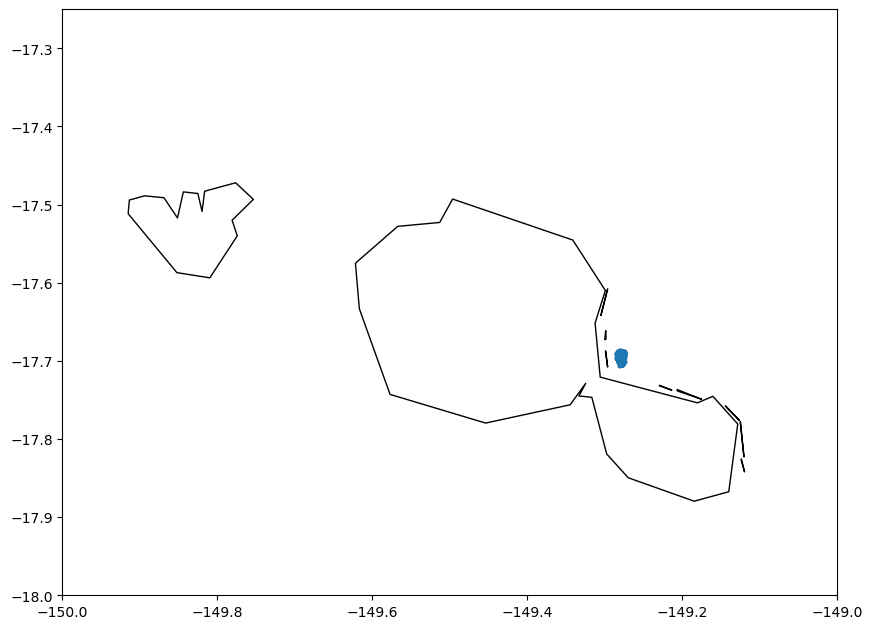

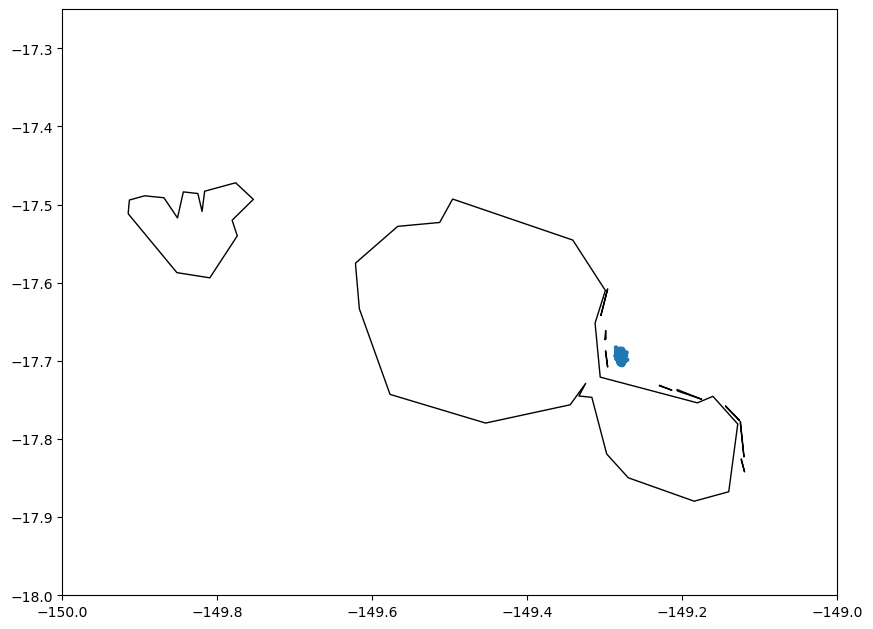

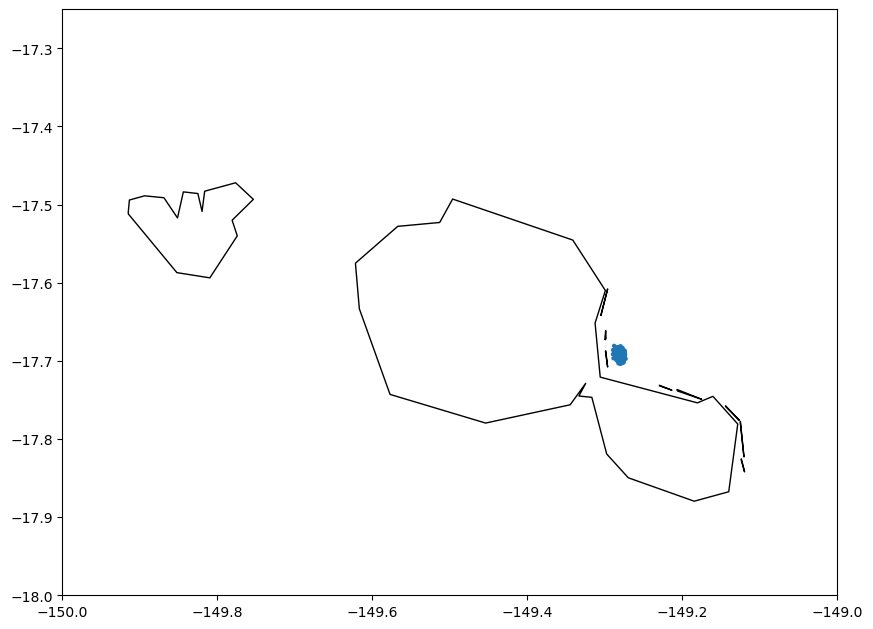

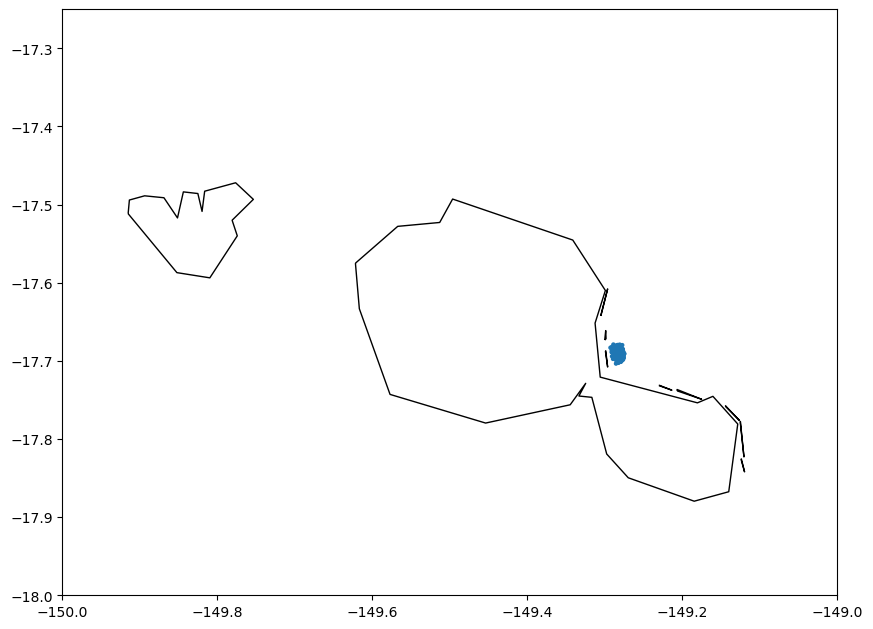

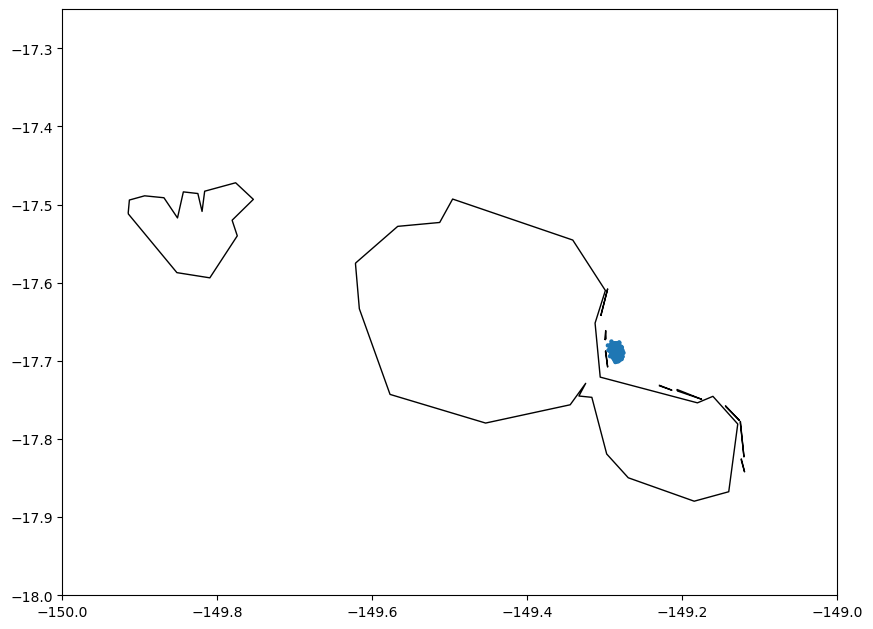

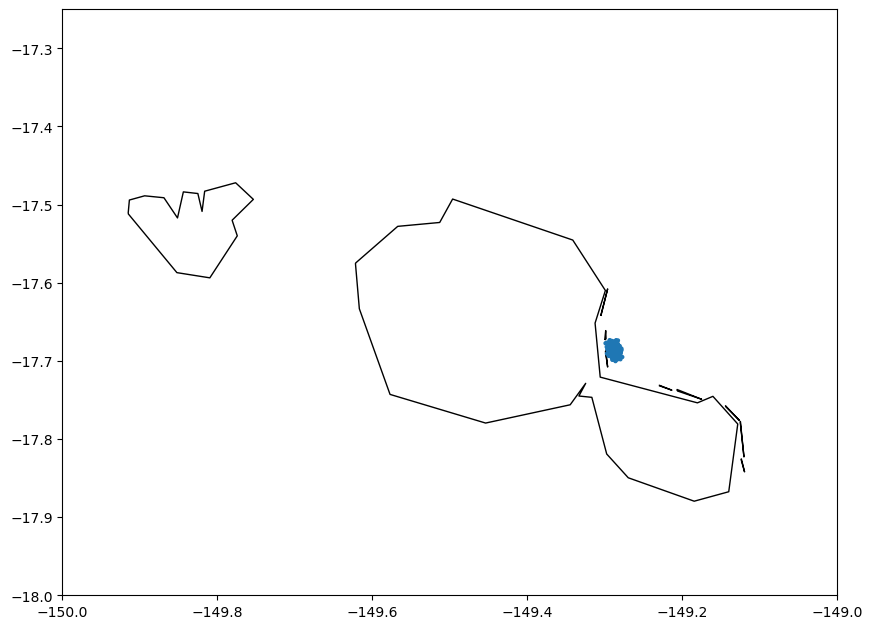

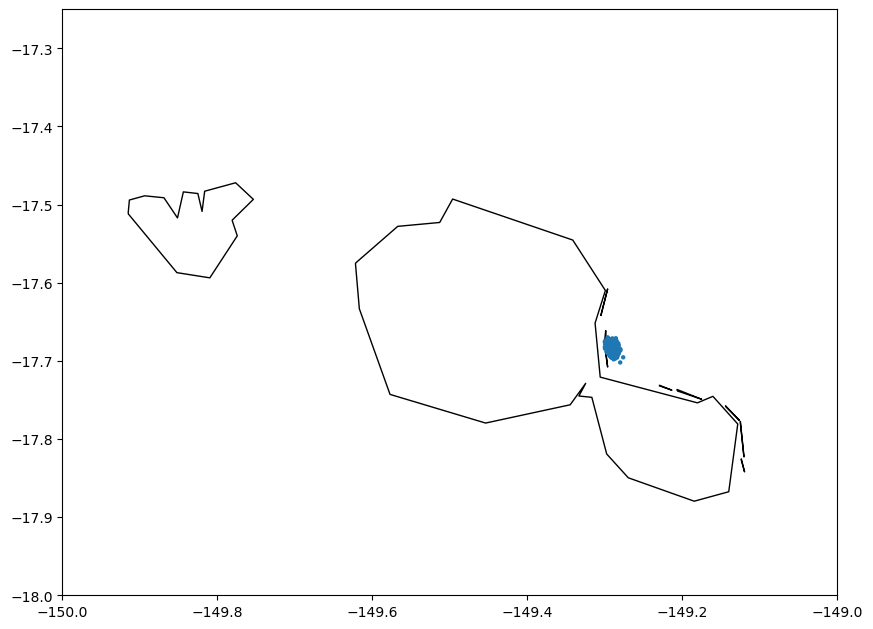

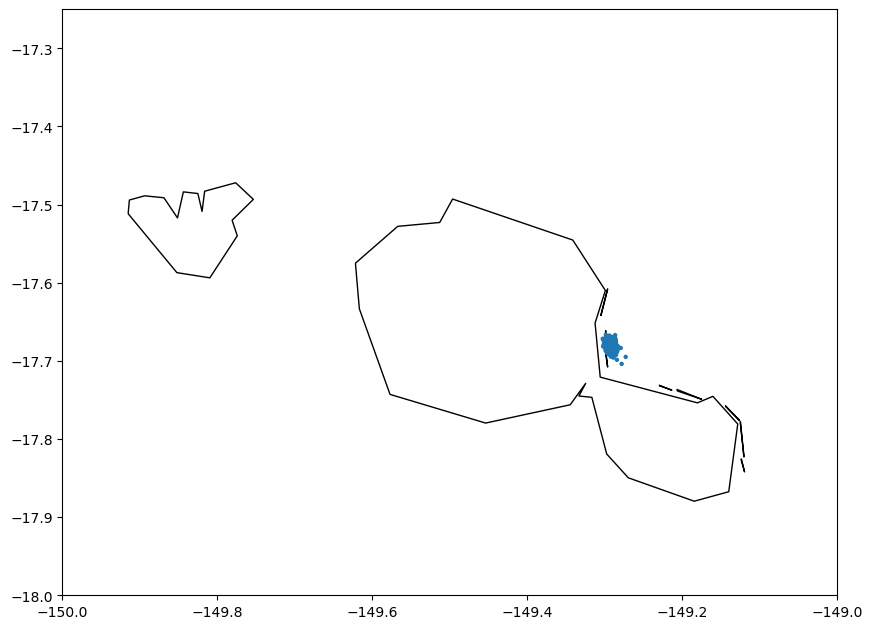

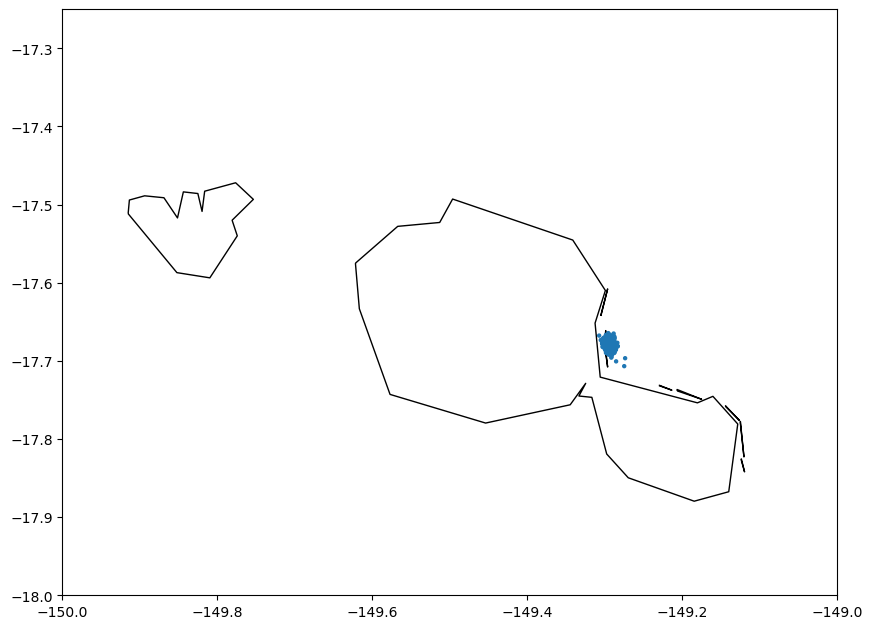

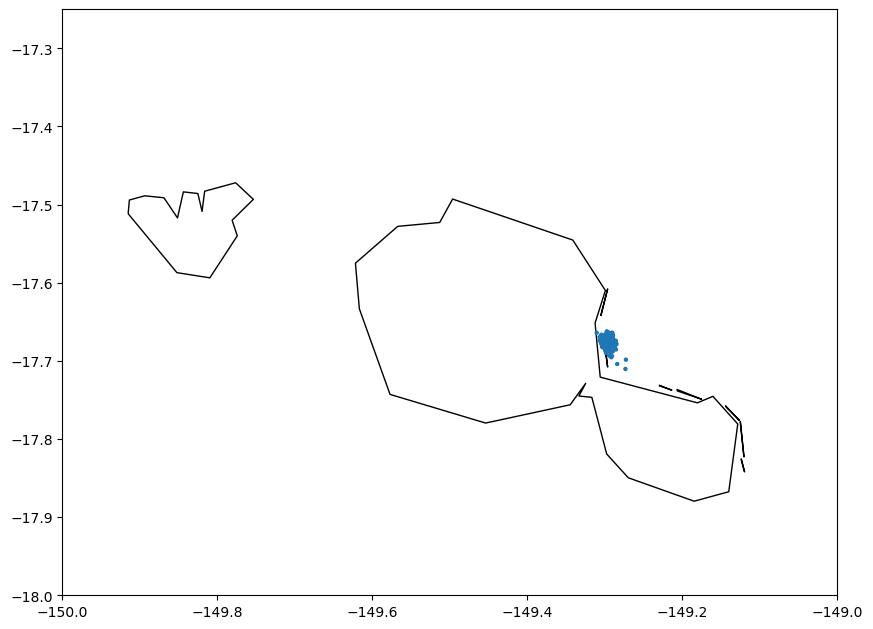

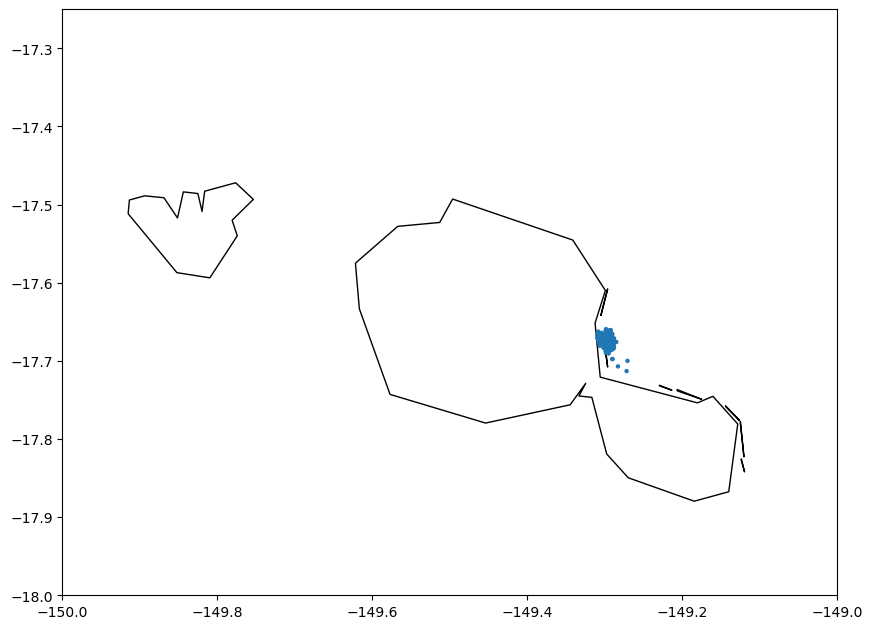

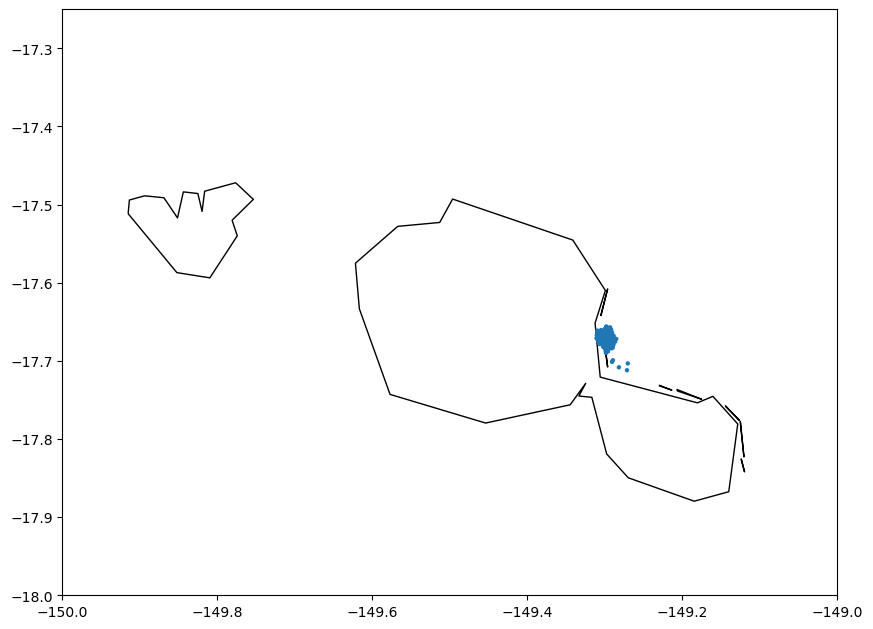

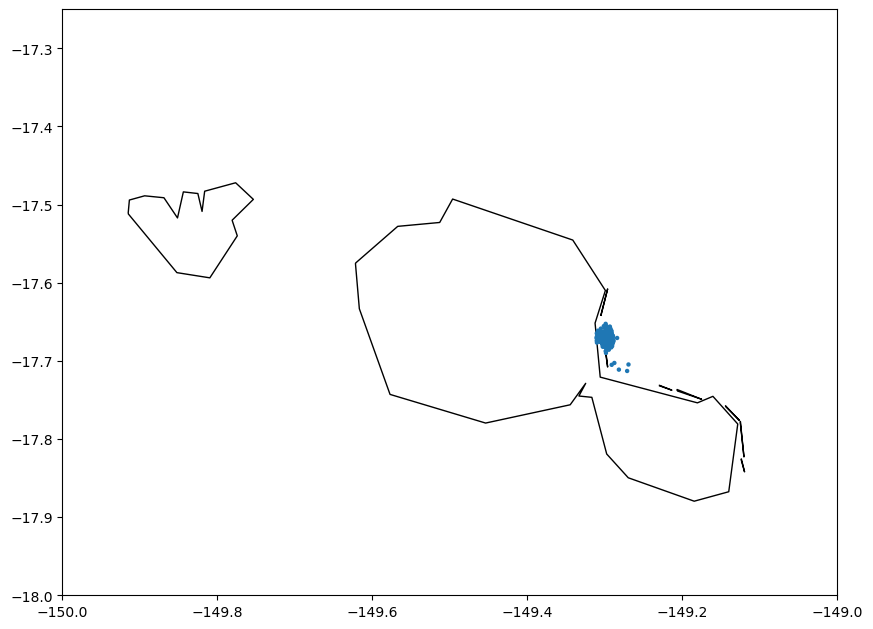

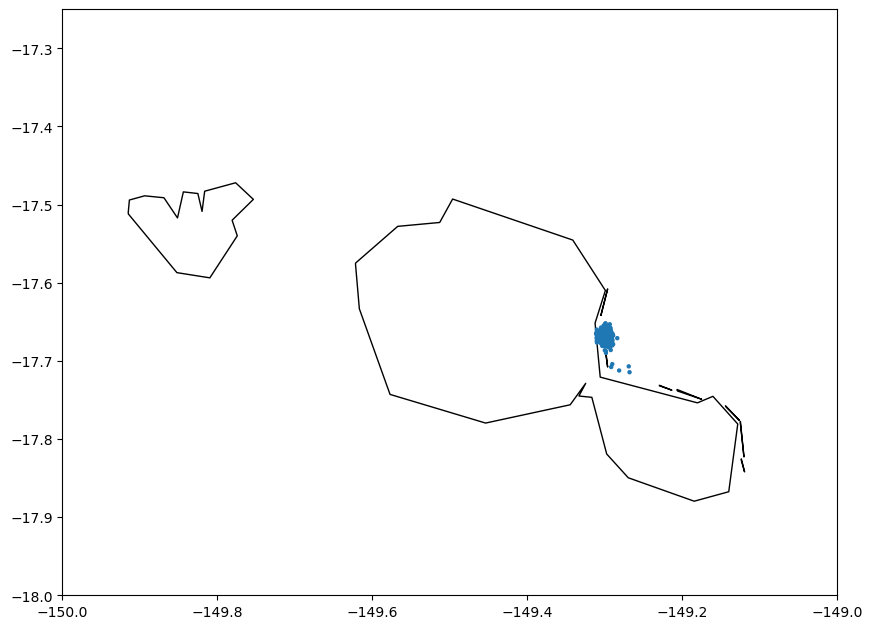

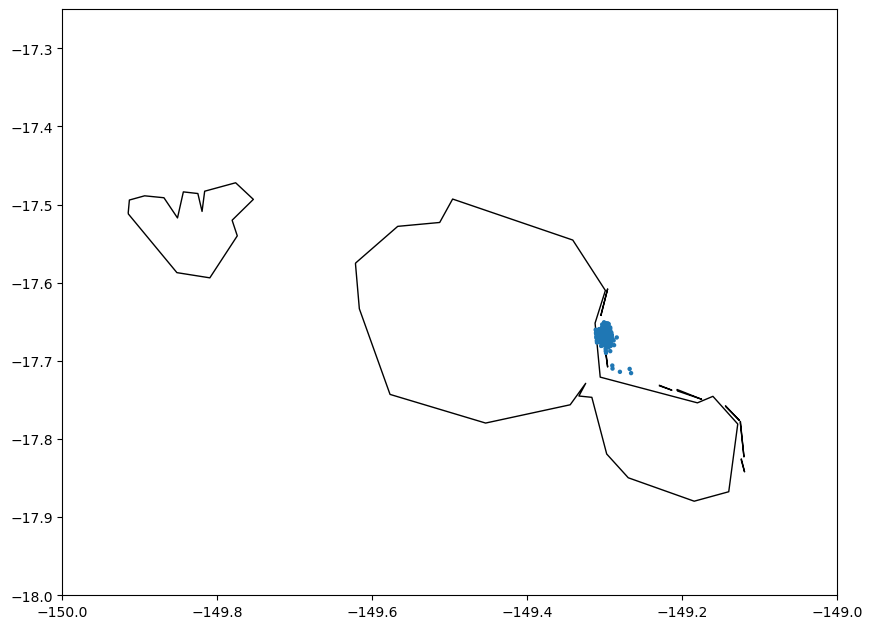

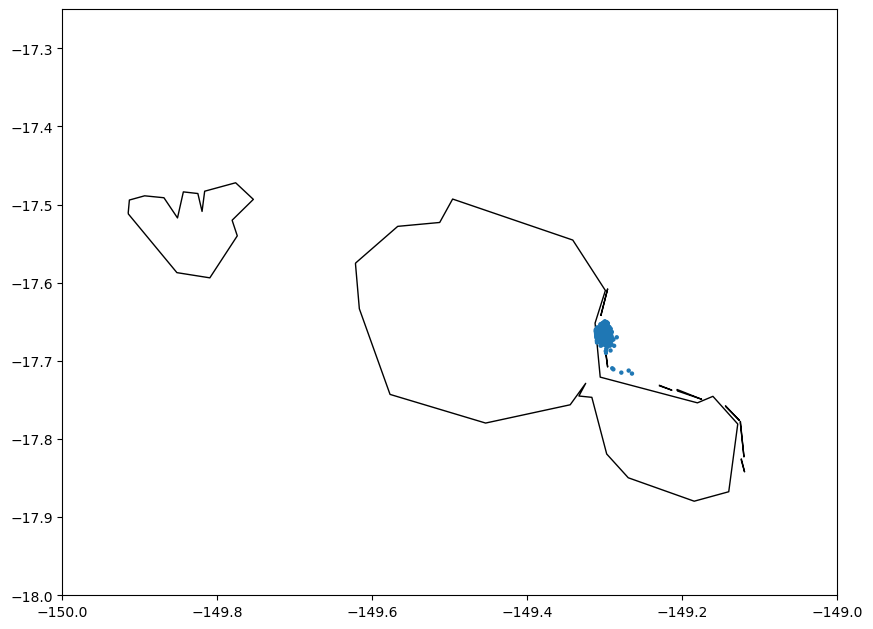

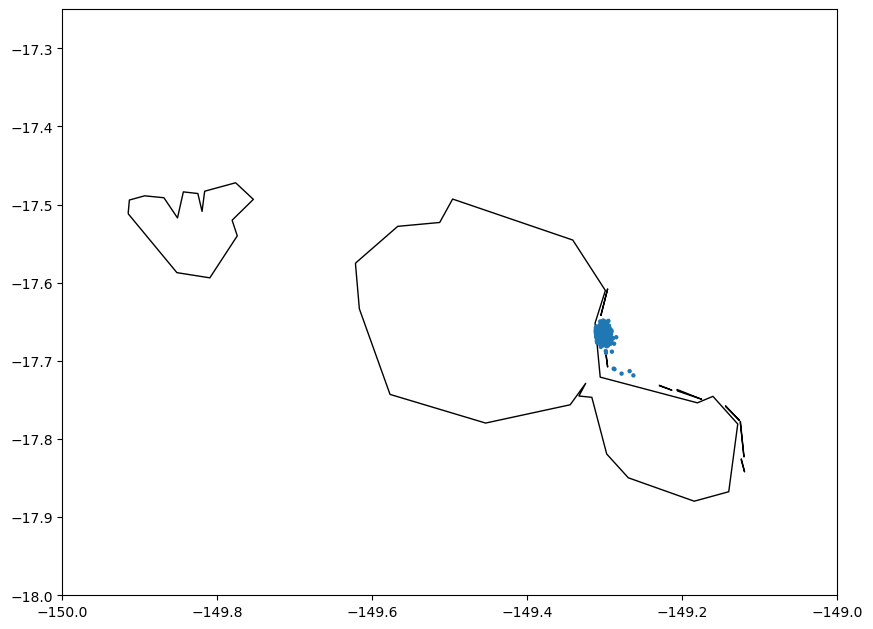

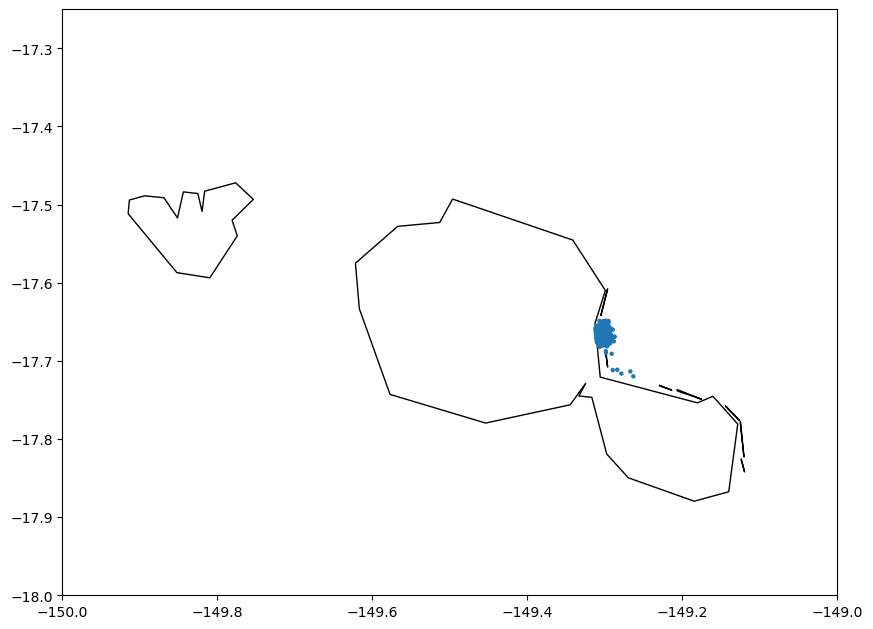

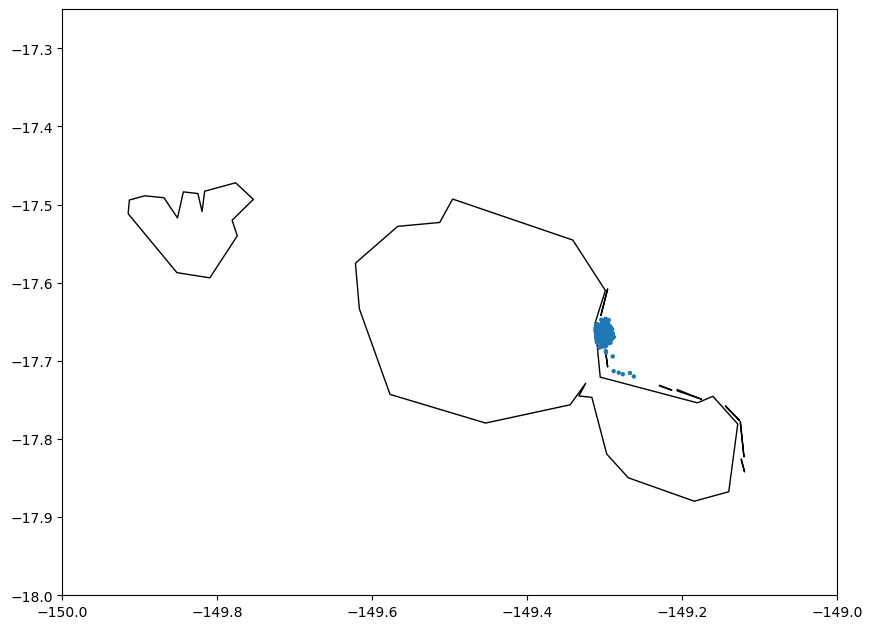

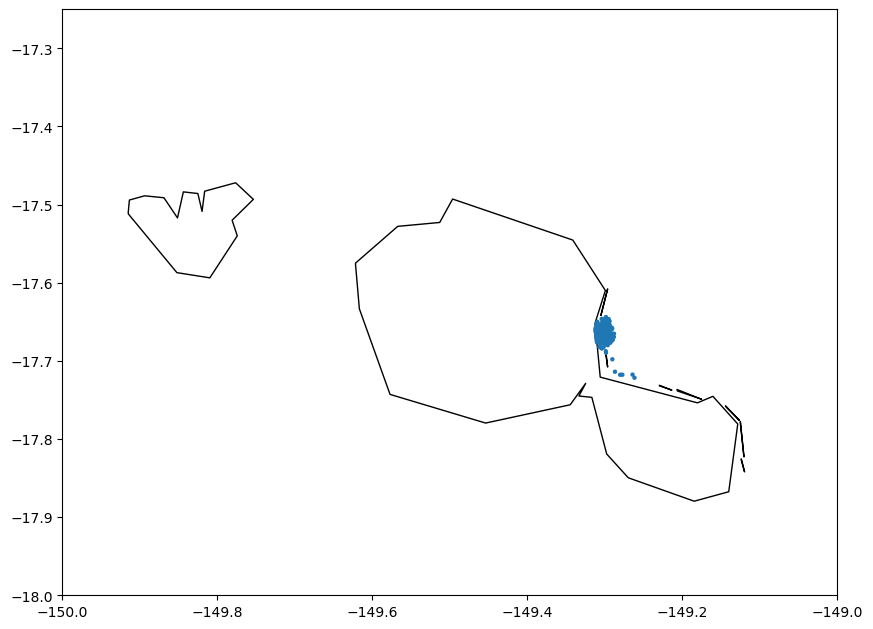

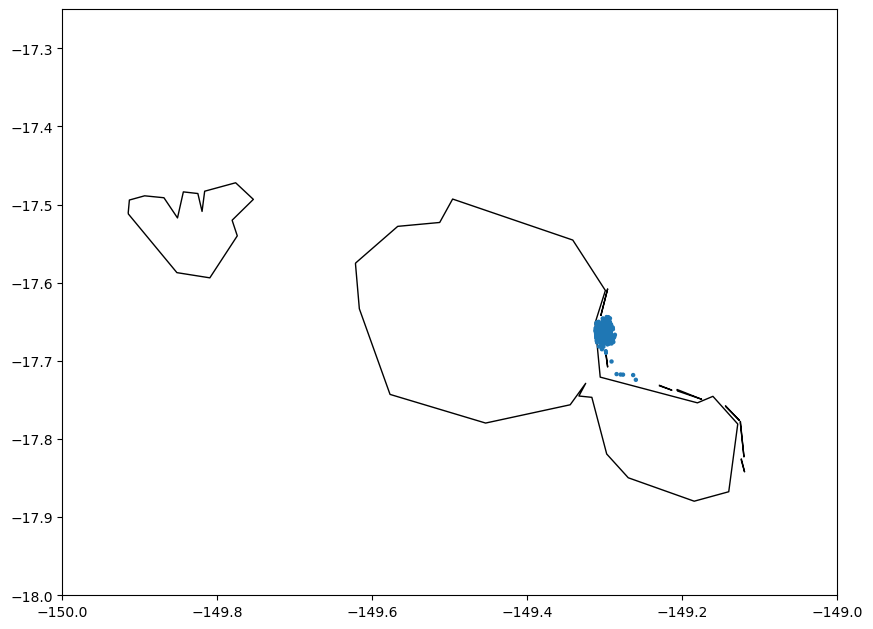

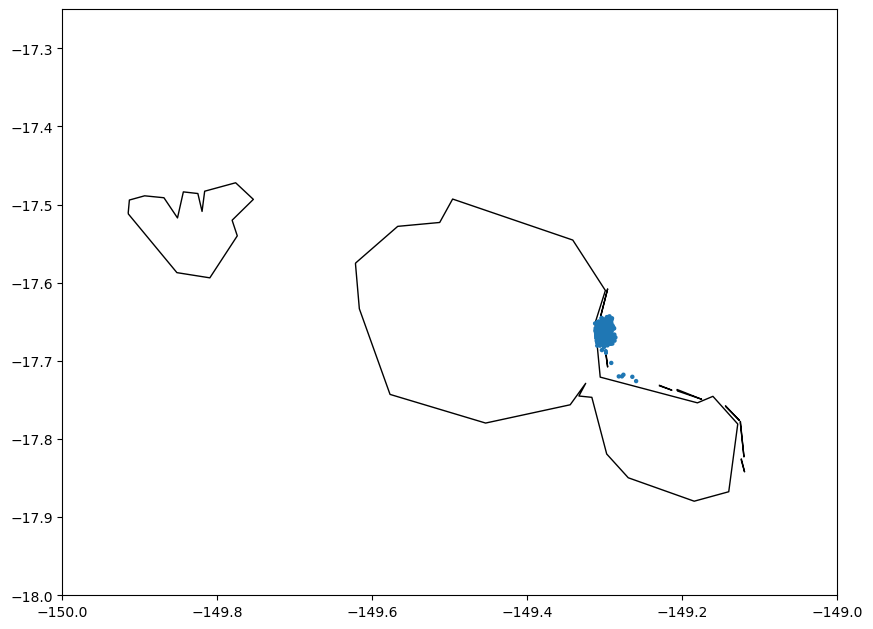

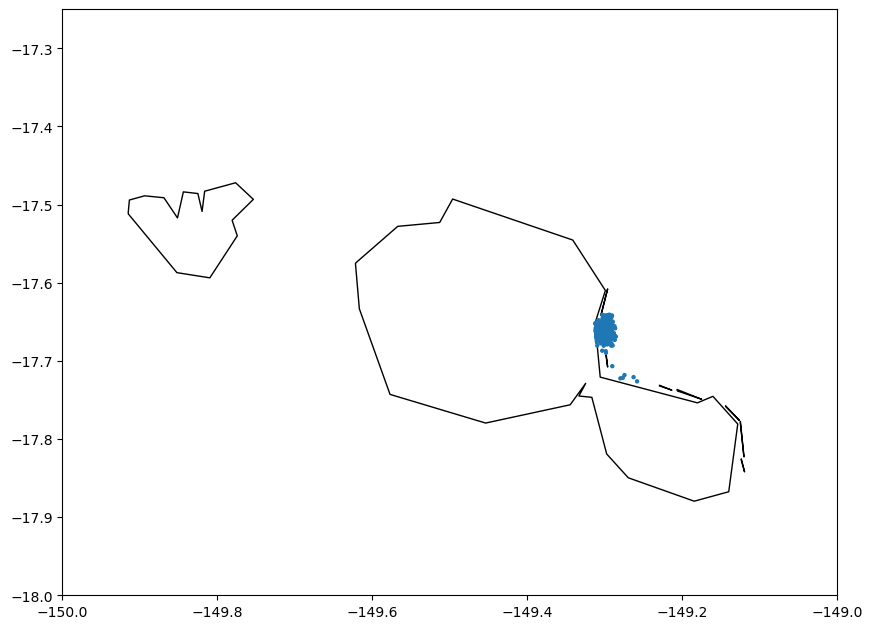

In [53]:
%matplotlib inline

for t in range(0,27):
# t = 1
    dss = ds.isel(time=t)
    # icurr = curr.isel(time = (t+12),depth=0)
    # Calculate the magnitude of the vectors
    # magnitude = np.sqrt(icurr.uo**2 + icurr.vo**2)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_aspect('equal')
    land.plot(ax=ax,color="white", edgecolor='black')
    # plt.quiver(icurr.lon,icurr.lat,icurr.uo,icurr.vo, magnitude,cmap='viridis',linewidth=0.05)
    ax.scatter(dss.longitude,dss.latitude,dss.non_evaporative_volume)
    
    # ax.scatter(18,41,color='r')
    
    plt.xlim(-150,-149)
    plt.ylim(-18,-17.25)

    plt.savefig(f'/Users/iatake/Dropbox (CMCC)/Work/MEDSLIK-II and Pyslick/Medslik-II/cases/cook_island/out_files/MDK_SIM_2023_11_15_1150_cook_island/fig_test_{t:02d}.png',dpi=150)

(40.2, 41.7)

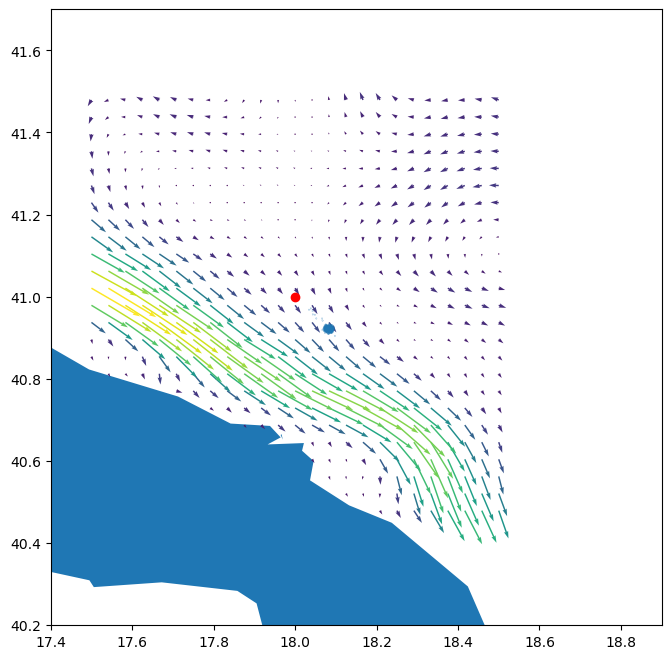

In [56]:
%matplotlib inline
t = 12
dss = ds.isel(time=t)
icurr = curr.isel(time = (t+12),depth=0)
# Calculate the magnitude of the vectors
magnitude = np.sqrt(icurr.uo**2 + icurr.vo**2)

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_aspect('equal')
land.plot(ax=ax)
plt.quiver(icurr.lon,icurr.lat,icurr.uo,icurr.vo, magnitude,cmap='viridis',linewidth=0.05)
ax.scatter(dss.longitude,dss.latitude,dss.non_evaporative_volume)

ax.scatter(18,41,color='r')

plt.xlim(17.4,18.9)
plt.ylim(40.2,41.7)

(40.2, 41.7)

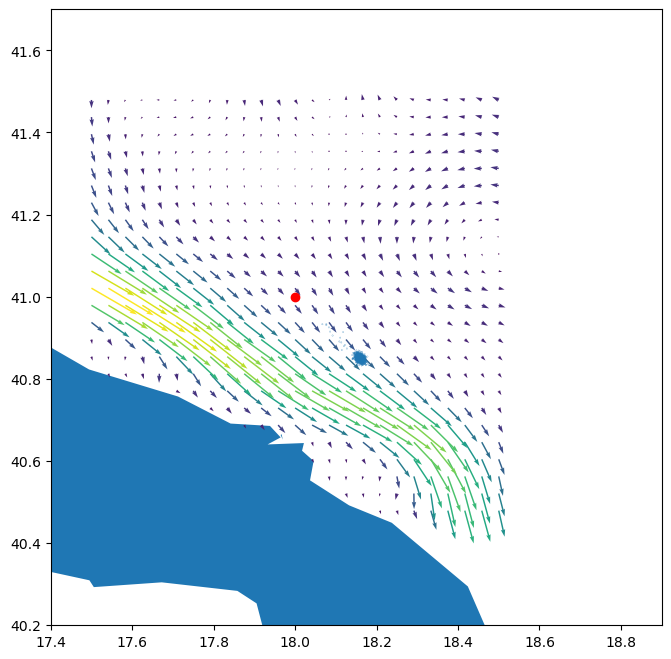

In [57]:
%matplotlib inline
t = 24
dss = ds.isel(time=t)
icurr = curr.isel(time = (t+12),depth=0)
# Calculate the magnitude of the vectors
magnitude = np.sqrt(icurr.uo**2 + icurr.vo**2)

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_aspect('equal')
land.plot(ax=ax)
plt.quiver(icurr.lon,icurr.lat,icurr.uo,icurr.vo, magnitude,cmap='viridis',linewidth=0.05)
ax.scatter(dss.longitude,dss.latitude,dss.non_evaporative_volume)

ax.scatter(18,41,color='r')

plt.xlim(17.4,18.9)
plt.ylim(40.2,41.7)

(40.2, 41.7)

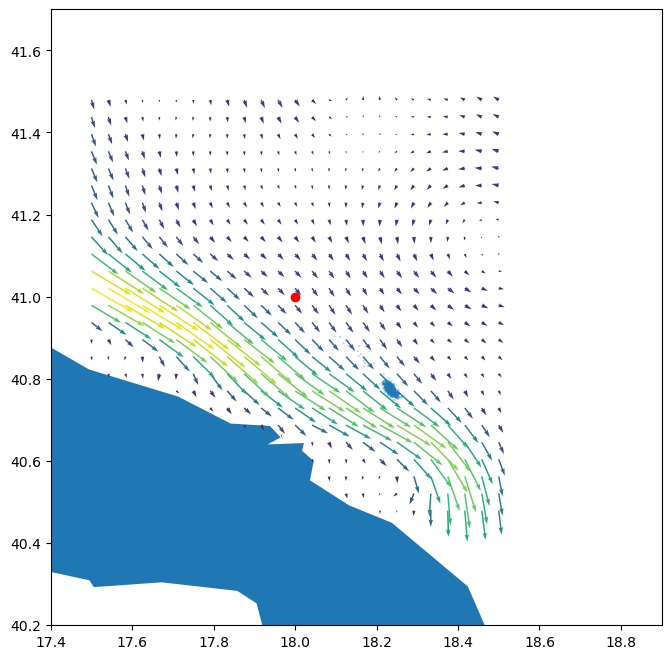

In [59]:
%matplotlib inline
t = 34
dss = ds.isel(time=t)
icurr = curr.isel(time = (t+12),depth=0)
# Calculate the magnitude of the vectors
magnitude = np.sqrt(icurr.uo**2 + icurr.vo**2)

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_aspect('equal')
land.plot(ax=ax)
plt.quiver(icurr.lon,icurr.lat,icurr.uo,icurr.vo, magnitude,cmap='viridis',linewidth=0.05)
ax.scatter(dss.longitude,dss.latitude,dss.non_evaporative_volume)

ax.scatter(18,41,color='r')

plt.xlim(17.4,18.9)
plt.ylim(40.2,41.7)

(40.2, 41.7)

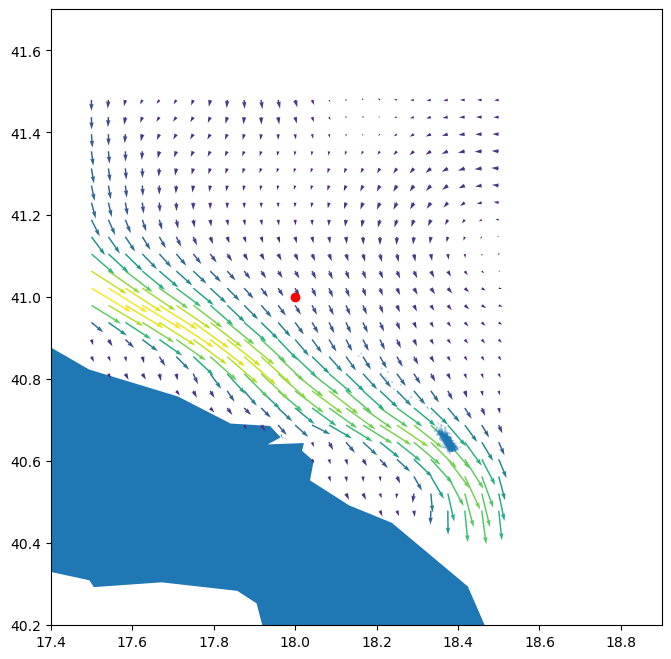

In [58]:
%matplotlib inline
t = 46
dss = ds.isel(time=t)
icurr = curr.isel(time = (t+12),depth=0)
# Calculate the magnitude of the vectors
magnitude = np.sqrt(icurr.uo**2 + icurr.vo**2)

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_aspect('equal')
land.plot(ax=ax)
plt.quiver(icurr.lon,icurr.lat,icurr.uo,icurr.vo, magnitude,cmap='viridis',linewidth=0.05)
ax.scatter(dss.longitude,dss.latitude,dss.non_evaporative_volume)

ax.scatter(18,41,color='r')

plt.xlim(17.4,18.9)
plt.ylim(40.2,41.7)